In [1]:
import numpy as np
import pandas as pd
import arviz as az
import numpyro
import numpyro.infer.initialization as init
import matplotlib.pyplot as plt

from jax import random
from numpyro.infer import MCMC, NUTS, SVI
from numpyro.optim import Adam
from numpyro.infer.autoguide import AutoDelta, Trace_ELBO

from asteroglitch.model import Prior, Observed, Posterior

In [2]:
track = pd.read_csv('../examples/data/modes.csv')
track.head()

,frac_age,delta_nu_fit,nu_max,nu_0_1,nu_0_2,nu_0_3,nu_0_4,nu_0_5,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,surface_he4
0,0.000016,11.884045,150.680452,0.0,34.481794,49.329712,63.195077,75.913367,87.630758,99.483102,...,392.064627,403.710370,415.297909,426.924218,438.655667,450.550178,462.546781,474.658899,486.825847,0.239966
1,0.000017,12.140476,154.893200,0.0,35.203007,50.376320,64.548471,77.583389,89.569246,101.679667,...,400.620086,412.538305,424.386957,436.252351,448.212638,460.326691,472.558635,484.919720,497.325734,0.239967
2,0.000017,12.343045,158.238356,0.0,35.772049,51.202159,65.616199,78.900744,91.100159,103.413323,...,407.368711,419.505074,431.563921,443.619056,455.762984,468.048949,480.469626,493.018551,505.616340,0.239968
3,0.000018,12.503403,160.898485,0.0,36.222266,51.855582,66.460893,79.942765,92.312228,104.785371,...,412.708426,425.019262,437.245702,449.452226,461.742276,474.164224,486.734715,499.427290,512.179364,0.239969
4,0.000018,12.633487,163.061612,0.0,36.587368,52.385499,67.145867,80.787635,93.295718,105.898357,...,417.037759,429.491253,441.854064,454.184875,466.594022,479.127384,491.819429,504.626946,517.505773,0.239969


In [3]:
profile = track.loc[600]

In [4]:
nu_index = [f'nu_0_{i}' for i in range(10, 30)]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [5]:
n = np.arange(10, 30)

In [6]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_fit = profile['delta_nu_fit']
print('delta_nu ~', round(delta_nu_fit, 2), 'muHz')

nu_max ~ 2853.19 muHz
delta_nu ~ 128.7 muHz


In [7]:
nu_err = 1e-6 * (nu - nu_max_sca)**2

In [8]:
nu_obs = np.random.normal(nu, nu_err)

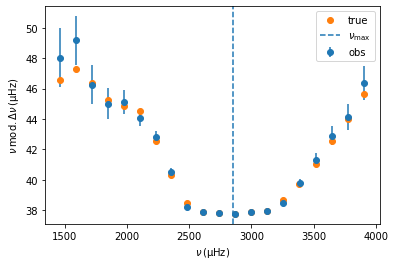

In [9]:
nu_mod = nu % delta_nu_fit
nu_mod_obs = nu_obs % delta_nu_fit

fig, ax = plt.subplots()

ax.errorbar(nu_obs, nu_mod_obs, yerr=nu_err, fmt='o', label='obs')
ax.plot(nu, nu_mod, 'o', label='true')

ax.axvline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [10]:
epsilon = [1.3, 0.2]
alpha = [np.log(0.001), 1.0]
delta_nu = [delta_nu_fit, 1.0]
nu_max = [nu_max_sca, 0.05*nu_max_sca]

In [11]:
prior = Prior(delta_nu, nu_max, epsilon, alpha, n=n)

In [12]:
prior.delta_nu

[128.69939436323318, 1.0]

In [13]:
# num_warmup, num_samples, num_chains = 2000, 2000, 4

# rng_key = random.PRNGKey(53)
# rng_keys = random.split(rng_key, num_chains)

# kernel = NUTS(prior.model, target_accept_prob=0.99, init_strategy=init.init_to_median, step_size=0.1)
# mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [14]:
# mcmc.run(rng_keys)

In [15]:
# trace = az.from_numpyro(mcmc)
# az.plot_trace(trace);

In [16]:
observed = Observed(nu_obs, nu_err)

In [17]:
posterior = Posterior(prior, observed)

In [18]:
# model = jax.pmap(posterior.model)
model = posterior.model

In [19]:
optimizer = Adam(step_size=0.0005)
loss = Trace_ELBO()

guide = AutoDelta(model)
svi = SVI(model, guide, optimizer, loss)

In [20]:
svi_result = svi.run(random.PRNGKey(0), 10000)

100%|██████████| 10000/10000 [00:06<00:00, 1488.09it/s, init loss: 116012.0212, avg. loss [9501-10000]: 20.1180]


In [21]:
svi_result.params

{'alpha_auto_loc': DeviceArray(0.00214742, dtype=float64),
 'b0_auto_loc': DeviceArray(0.00723321, dtype=float64),
 'b1_auto_loc': DeviceArray(1.58513558e-06, dtype=float64),
 'c0_auto_loc': DeviceArray(1970730.28372283, dtype=float64),
 'delta_nu_auto_loc': DeviceArray(128.61714733, dtype=float64),
 'epsilon_auto_loc': DeviceArray(1.30598408, dtype=float64),
 'nu_err_auto_loc': DeviceArray(0.09160223, dtype=float64),
 'nu_max_auto_loc': DeviceArray(2819.40593725, dtype=float64),
 'phi_cz_unwrapped_auto_loc': DeviceArray(0.08711589, dtype=float64),
 'phi_he_unwrapped_auto_loc': DeviceArray(-0.51314261, dtype=float64),
 'tau_cz_auto_loc': DeviceArray(0.00055344, dtype=float64),
 'tau_he_auto_loc': DeviceArray(0.00015384, dtype=float64)}

In [22]:
num_warmup, num_samples, num_chains = 2000, 2000, 5

rng_key = random.PRNGKey(53)
rng_keys = random.split(rng_key, num_chains)

kernel = NUTS(model, target_accept_prob=0.99, init_strategy=init.init_to_median, step_size=0.1)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [23]:
mcmc.run(rng_keys)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [24]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
             alpha      0.00      0.00      0.00      0.00      0.00    290.90      1.02
                b0      0.03      0.03      0.02      0.00      0.05    945.11      1.01
                b1      0.00      0.00      0.00      0.00      0.00    384.86      1.02
                c0 3419633.04 705665.18 3418665.20 2203419.68 4507007.79    827.55      1.00
          delta_nu    128.81      0.35    128.81    128.26    129.43    334.57      1.01
           epsilon      1.27      0.06      1.27      1.17      1.37    354.42      1.01
            nu_err      0.12      0.05      0.12      0.05      0.19   1584.93      1.00
            nu_max   2846.55    136.41   2853.18   2612.28   3063.96    828.61      1.00
  phi_cz_unwrapped     -0.84      6.58      0.54    -12.01      8.94      2.67      3.93
  phi_he_unwrapped     -1.35      4.19     -1.26     -7.93      5.56      4.52      1.54
            tau_

In [26]:
# trace = az.from_numpyro(mcmc)

In [28]:
posterior = mcmc.get_samples(group_by_chain=True)

In [29]:
sample_stats = mcmc.get_extra_fields(group_by_chain=True)

In [30]:
trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

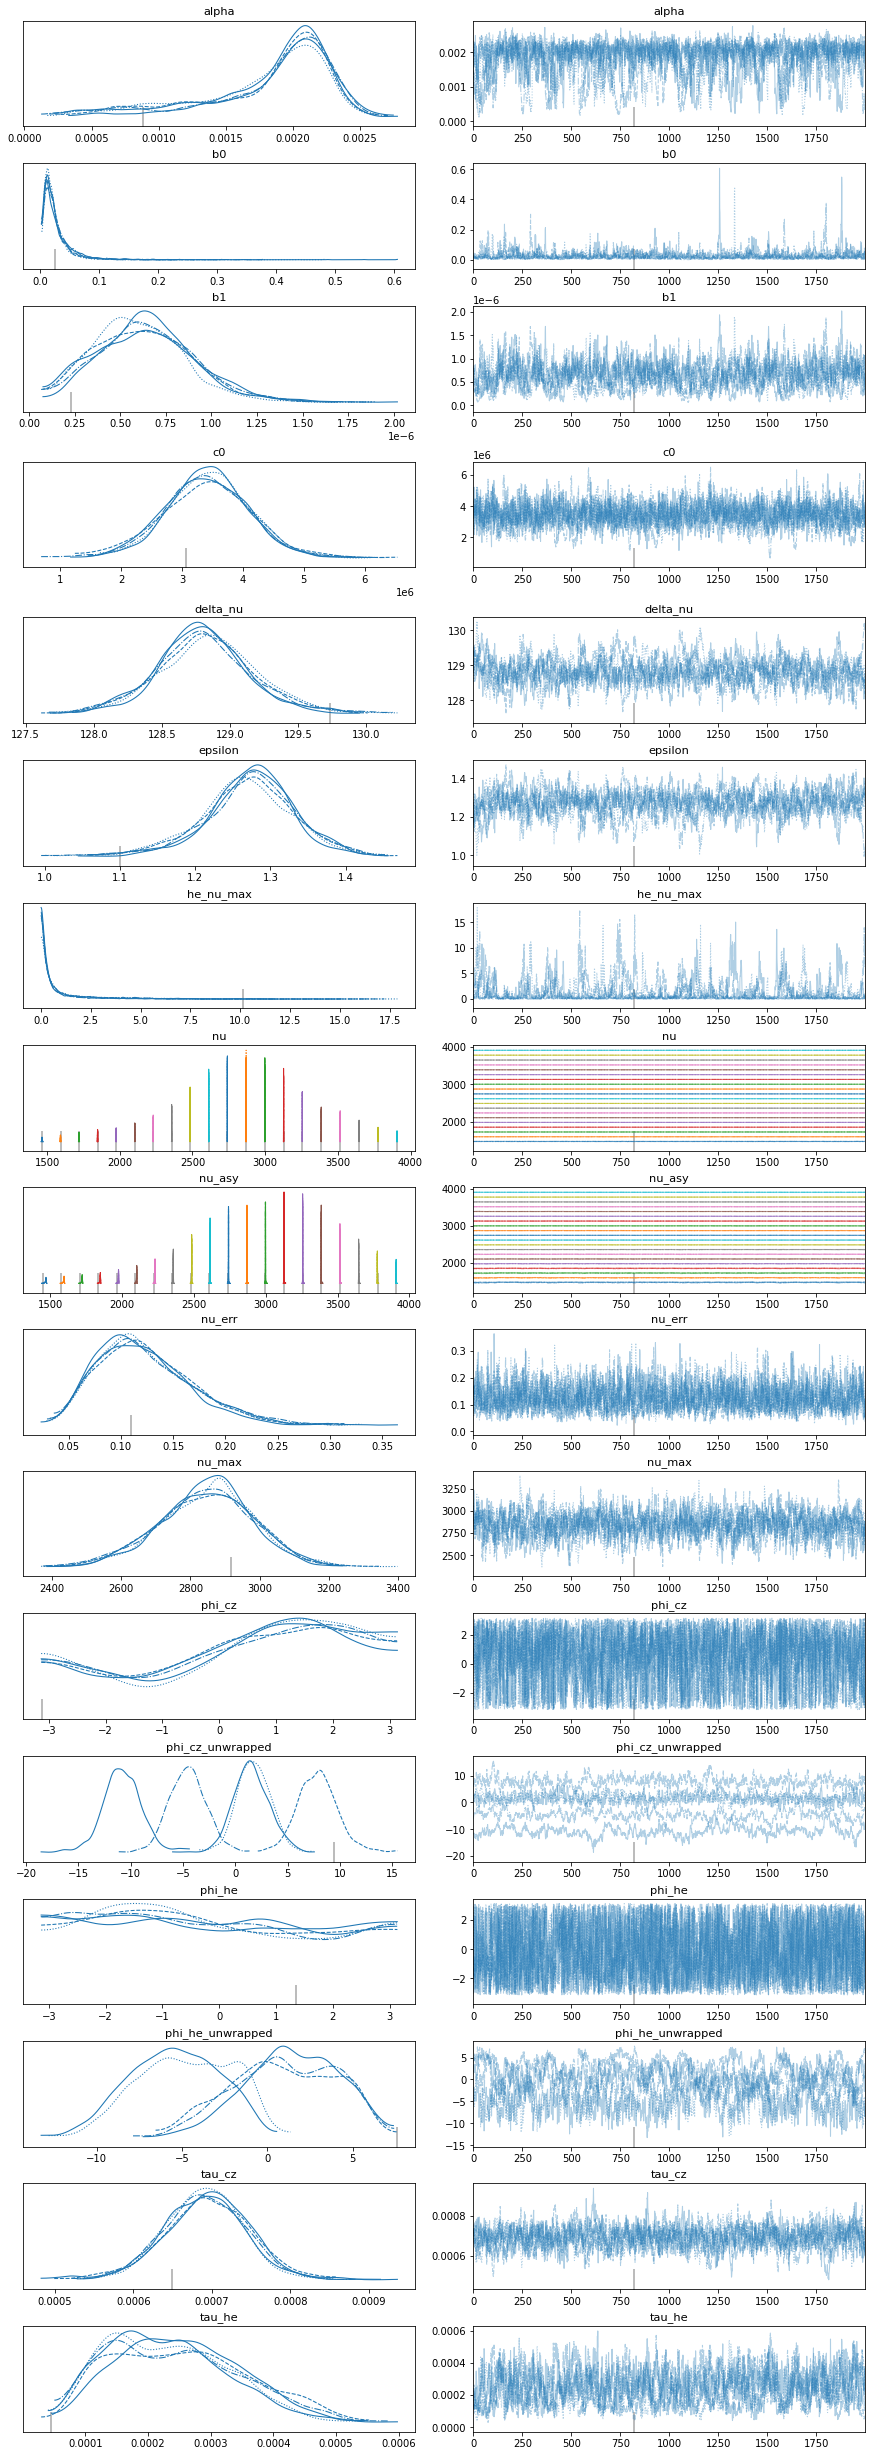

In [31]:
az.plot_trace(trace);